In [25]:
import gc
from all_stand_var import conv_dict,vent_cols3
from all_own_funct import memory_downscale,memory_upscale,evaluate
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from seaborn import heatmap
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import kurtosis
from matplotlib.backends.backend_pdf import PdfPages
import keras.backend as K
from RNN_LTSM_CHD import return_loaded_model
import pickle
import locale
import LR_build_CHD as pp
import tables
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

locale.setlocale(locale.LC_ALL, 'fr_FR')
output_folder = os.path.join(os.getcwd(), 'Results_LR_RF_CHD_v3','12u_result')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


In [26]:
import tables


df=pd.read_hdf(os.path.join('./Results_CHD_v5/final', 'processed_df.h5'),key='df',mode='r')
#df=memory_downscale(df)
print(df.info())




<class 'pandas.core.frame.DataFrame'>
MultiIndex: 978473 entries, (0, 7171037, Timestamp('2008-04-11 00:00:00')) to (77, 3536787, Timestamp('2020-01-10 00:00:00'))
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   pat_datetime     978473 non-null  datetime64[ns]
 1   pat_weight_act   978473 non-null  float16       
 2   mon_etco2        829237 non-null  float16       
 3   mon_hr           971134 non-null  float16       
 4   mon_ibp_mean     887213 non-null  float16       
 5   mon_rr           931288 non-null  float16       
 6   mon_sat          959128 non-null  float16       
 7   vent_m_fio2      973620 non-null  float16       
 8   vent_m_peep      960680 non-null  float16       
 9   vent_m_ppeak     977208 non-null  float16       
 10  vent_m_rr        978466 non-null  float16       
 11  vent_m_tv_exp    972433 non-null  float16       
 12  Age              978473 non-null  float16 

In [27]:
vent_cols3 = [ 'pat_datetime',  'mon_rr', 'mon_hr', 'mon_sat',
              'mon_etco2', 'vent_m_fio2', 'vent_m_ppeak','vent_m_peep',
             'mon_ibp_mean','pat_weight_act','vent_m_rr', 'vent_m_tv_exp','Age']
for col in vent_cols3:
    print(df[col].describe())

ipykernel_launcher:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
count                  978473
unique                 876783
top       2010-06-11 07:28:00
freq                        6
first     2008-04-11 15:08:00
last      2020-01-10 22:10:00
Name: pat_datetime, dtype: object
count    931288.000000
mean               NaN
std           0.000000
min          -3.580078
25%          -1.098633
50%          -0.478516
75%           0.141724
max           6.652344
Name: mon_rr, dtype: float64
count    971134.000000
mean               NaN
std           0.000000
min          -6.300781
25%          -1.116211
50%          -0.394531
75%           0.281738
max           8.851562
Name: mon_hr, dtype: float64
count    959128.000000
mean               NaN
std           0.000000
min          -8.054688

In [28]:
df=df.reset_index(drop=False)
df=memory_upscale(df)
print(len(df['Adnum'].unique()))
def fill_group(group):
    group=group.fillna(method='ffill').fillna(method='bfill')
    group=group.dropna(how='all',subset=['vent_m_ppeak','vent_m_peep','vent_m_fio2','vent_m_rr', 'vent_m_tv_exp'])
    return group
df=df.groupby(['pat_hosp_id','OK_datum','Adnum'],sort=False,as_index=False).apply(fill_group)
print(df.info())
print(len(df['Adnum'].unique()))

2149
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 978473 entries, (0, 0) to (2148, 978472)
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   level_0          978473 non-null  int64         
 1   pat_hosp_id      978473 non-null  int64         
 2   OK_datum         978473 non-null  datetime64[ns]
 3   pat_datetime     978473 non-null  datetime64[ns]
 4   pat_weight_act   978473 non-null  float64       
 5   mon_etco2        881490 non-null  float64       
 6   mon_hr           978471 non-null  float64       
 7   mon_ibp_mean     907487 non-null  float64       
 8   mon_rr           964997 non-null  float64       
 9   mon_sat          978292 non-null  float64       
 10  vent_m_fio2      974605 non-null  float64       
 11  vent_m_peep      962489 non-null  float64       
 12  vent_m_ppeak     977753 non-null  float64       
 13  vent_m_rr        978473 non-null  float64       
 14  ve

In [29]:
df=df.set_index(['level_0','pat_hosp_id','OK_datum'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 978473 entries, (0, 7171037, Timestamp('2008-04-11 00:00:00')) to (77, 3536787, Timestamp('2020-01-10 00:00:00'))
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   pat_datetime     978473 non-null  datetime64[ns]
 1   pat_weight_act   978473 non-null  float64       
 2   mon_etco2        881490 non-null  float64       
 3   mon_hr           978471 non-null  float64       
 4   mon_ibp_mean     907487 non-null  float64       
 5   mon_rr           964997 non-null  float64       
 6   mon_sat          978292 non-null  float64       
 7   vent_m_fio2      974605 non-null  float64       
 8   vent_m_peep      962489 non-null  float64       
 9   vent_m_ppeak     977753 non-null  float64       
 10  vent_m_rr        978473 non-null  float64       
 11  vent_m_tv_exp    974153 non-null  float64       
 12  Age              978473 non-null  float64 

0.0    720
Name: Reintub, dtype: int64
2012-11-28 22:34:00
2012-11-29 10:35:00


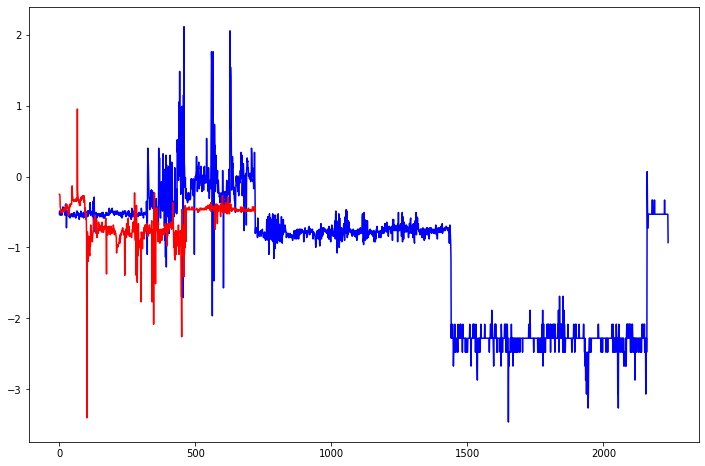

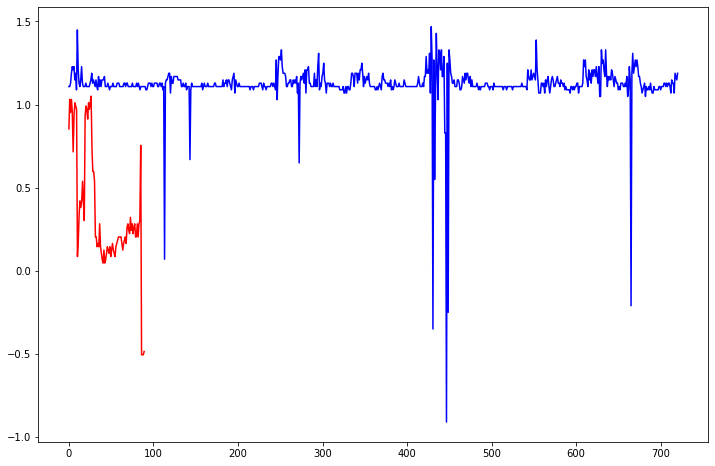

In [30]:

print(df[df.index.get_level_values('pat_hosp_id') == 8460454]['Reintub'].value_counts())
print(df[df.index.get_level_values('pat_hosp_id') == 9852266]['pat_datetime'].min())
print(df[df.index.get_level_values('pat_hosp_id') == 9852266]['pat_datetime'].max())
plt.plot(np.linspace(start=0,stop=2238,num=2238),df[df.index.get_level_values('pat_hosp_id') == 3204962]['vent_m_ppeak'],'b-')
plt.plot(np.linspace(start=0,stop=720,num=720),df[df.index.get_level_values('pat_hosp_id') == 9852266]['vent_m_ppeak'],'r-')
fig=plt.gcf()
fig.set_size_inches(12, 8)
plt.show()




plt.plot(np.linspace(start=0,stop=720,num=720),df[df.index.get_level_values('pat_hosp_id') == 1497966]['vent_m_ppeak'],'b-')
plt.plot(np.linspace(start=0,stop=89,num=89),df[df.index.get_level_values('pat_hosp_id') == 1921415]['vent_m_ppeak'],'r-')
fig=plt.gcf()
fig.set_size_inches(12, 8)
plt.show()

In [31]:
"""
try:
    pdf = PdfPages(os.path.join(output_folder,f"Figures_raw.pdf"))
except PermissionError:
    os.remove(os.path.join(output_folder,f"Figures_raw.pdf"))
df_t=df.head(8000)
for gr,pat in df_t.groupby('Adnum',sort=False):
    for cols in df_t.columns:
        plt.plot(np.linspace(start=0,stop=len(pat),num=len(pat)),pat[cols],'b-')
        a=df_t['Reintub'].max()
        p=pat['Adnum'].unique()
        plt.title(f'{p},{a},{cols}')
        plt.show()
        fig=plt.gcf()
        pdf.savefig(fig)
        plt.close(fig)
pdf.close()
"""


'\ntry:\n    pdf = PdfPages(os.path.join(output_folder,f"Figures_raw.pdf"))\nexcept PermissionError:\n    os.remove(os.path.join(output_folder,f"Figures_raw.pdf"))\ndf_t=df.head(8000)\nfor gr,pat in df_t.groupby(\'Adnum\',sort=False):\n    for cols in df_t.columns:\n        plt.plot(np.linspace(start=0,stop=len(pat),num=len(pat)),pat[cols],\'b-\')\n        a=df_t[\'Reintub\'].max()\n        p=pat[\'Adnum\'].unique()\n        plt.title(f\'{p},{a},{cols}\')\n        plt.show()\n        fig=plt.gcf()\n        pdf.savefig(fig)\n        plt.close(fig)\npdf.close()\n'

In [32]:
import datetime as dt
from sklearn.preprocessing import StandardScaler

df=df.reset_index(drop=False)
def index_1hr(group):
    #grouped = pd.Grouper(key='pat_datetime', freq='1H')
    #group['idx_1hr']=group.groupby(grouped,sort=False).ngroup().add(1)
    #group['idx_1hr']=group['idx_1hr'].apply(str)
    group['mis'] = group['pat_datetime'].max()-group['pat_datetime'].min()
    group['mis'] = group['mis'].dt.seconds.divide(60)
    return group
#df.reset_index(drop=True,inplace=True)
df=df.groupby('Adnum',sort=False,as_index=False).apply(index_1hr)
print((df['Adnum'].value_counts()))
df[['mis']]=StandardScaler().fit_transform(df[['mis']])
df=df.set_index(['pat_hosp_id','OK_datum'])
print(df.info())

2070    1440
755      720
1373     720
1184     720
672      720
        ... 
528        6
2024       5
529        3
1905       3
1587       2
Name: Adnum, Length: 2149, dtype: int64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 978473 entries, (7171037, Timestamp('2008-04-11 00:00:00')) to (3536787, Timestamp('2020-01-10 00:00:00'))
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   level_0          978473 non-null  int64         
 1   pat_datetime     978473 non-null  datetime64[ns]
 2   pat_weight_act   978473 non-null  float64       
 3   mon_etco2        881490 non-null  float64       
 4   mon_hr           978471 non-null  float64       
 5   mon_ibp_mean     907487 non-null  float64       
 6   mon_rr           964997 non-null  float64       
 7   mon_sat          978292 non-null  float64       
 8   vent_m_fio2      974605 non-null  float64       
 9   vent_m_peep      962489 non-

In [34]:
pat=pd.read_excel(r'Results_CHD\admissiondate_CHD0.xlsx',
                    parse_dates=['OK_datum'],index_col=0)
group=pat.groupby('pat_hosp_id',sort=False).max().reset_index()
group.drop_duplicates('pat_hosp_id',inplace=True)

df_train,df_val,df_test=pp.split_stratified_into_train_val_test(group, stratify_colname='Reintub',
                                         frac_train=0.7, frac_val=0.1, frac_test=0.2,
                                         random_state=1)

train_pat=df_train['pat_hosp_id'].unique()
test_pat=df_test['pat_hosp_id'].unique()
val_pat=df_val['pat_hosp_id'].unique()

df_train = df[df.index.get_level_values('pat_hosp_id').isin(train_pat)]
df_val = df[df.index.get_level_values('pat_hosp_id').isin(val_pat)]
df_test = df[df.index.get_level_values('pat_hosp_id').isin(test_pat)]

In [35]:

def y_modelling(df):
    y=df[['Reintub','Adnum']]
    y=y.groupby(['Adnum'],sort=False).agg(['max'])
    y.columns = ["_".join(a) for a in y.columns.to_flat_index()]
    y=y.reset_index().drop_duplicates().set_index('Adnum')
    y=y[~y.index.duplicated(keep='last')]
    return y
Y_TRAIN=y_modelling(df_train)
Y_TEST=y_modelling(df_test)
Y_VAL=y_modelling(df_val)



In [36]:
print(Y_TRAIN.value_counts())
print(Y_VAL.value_counts())
print(Y_TEST.value_counts())
Y_TRAIN=Y_TRAIN['Reintub_max'].to_numpy()
Y_TEST=Y_TEST['Reintub_max'].to_numpy()
Y_VAL=Y_VAL['Reintub_max'].to_numpy()
Y_TRAIN=np.append(Y_TRAIN,Y_VAL)

Reintub_max
0.0            1427
1.0              87
dtype: int64
Reintub_max
0.0            199
1.0             13
dtype: int64
Reintub_max
0.0            396
1.0             27
dtype: int64


In [37]:
def lin_reg_coef(series):
    x=np.linspace(start=0,stop=len(series),num=len(series))
    y=series.values
    model=LinearRegression().fit(x,y)
    coef=model.coef_[0]
    
    

def x_modelling(df):
    #df=df[['Adnum','mis','pat_weight_act','Age','Diagnose']]
    df=df.drop(['Extubation_date','level_0','pat_datetime', 'Reintub'],axis=1)
    print(df.info())
    df=df.groupby(['Adnum'],sort=False).agg(['mean','std'])
    df.columns = ["_".join(a) for a in df.columns.to_flat_index()]
    df=df.reset_index().drop_duplicates().set_index('Adnum')
    return df
X_TRAIN=memory_upscale(x_modelling(df_train))
X_TEST=memory_upscale(x_modelling(df_test))
X_VAL=memory_upscale(x_modelling(df_val))



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 688151 entries, (7171037, Timestamp('2008-04-11 00:00:00')) to (3536787, Timestamp('2020-01-10 00:00:00'))
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Adnum           688151 non-null  int64  
 1   mis             688151 non-null  float64
 2   pat_weight_act  688151 non-null  float64
 3   Age             688151 non-null  float64
 4   Diagnose        688151 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 29.0 MB
None
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 195495 entries, (9596291, Timestamp('2008-04-24 00:00:00')) to (2609893, Timestamp('2019-12-27 00:00:00'))
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Adnum           195495 non-null  int64  
 1   mis             195495 non-null  float64
 2   pat_weight_act  195495 non-null  float64
 3   Age      

In [38]:
print(X_TRAIN.info())

X_TRAIN=X_TRAIN.fillna(value=0)
X_VAL=X_VAL.fillna(value=0)
X_TEST=X_TEST.fillna(value=0)
print(X_TEST.info())
X_TRAIN=X_TRAIN.append(X_VAL)

f = open(os.path.join(output_folder, 'x_train.txt'), 'wb')
pickle.dump(X_TRAIN, f)
f.close()

f = open(os.path.join(output_folder, 'x_test.txt'), 'wb')
pickle.dump(X_TEST, f)
f.close()

f = open(os.path.join(output_folder, 'y_train.txt'), 'wb')
pickle.dump(Y_TRAIN, f)
f.close()

f = open(os.path.join(output_folder, 'y_test.txt'), 'wb')
pickle.dump(Y_TEST, f)
f.close()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1514 entries, 0 to 2148
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mis_mean             1514 non-null   float64
 1   pat_weight_act_mean  1514 non-null   float64
 2   Age_mean             1514 non-null   float64
 3   Diagnose_mean        1514 non-null   float64
dtypes: float64(4)
memory usage: 59.1 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 423 entries, 2 to 2145
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mis_mean             423 non-null    float64
 1   pat_weight_act_mean  423 non-null    float64
 2   Age_mean             423 non-null    float64
 3   Diagnose_mean        423 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 16.5 KB
None


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(X_TRAIN, Y_TRAIN)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=26, bootstrap=True 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=26, bootstrap=True, total=   0.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=26, bootstrap=True 
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=26, bootstrap=True, total=   0.7s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=26, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=26, bootstrap=True, total=   0.9s
[CV] n_estimators=600, min_samples_split=10, min_

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 14, 18, 22, 26, 30,
                                                      34, 38, 42, 46, 50,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [40]:
from sklearn.metrics import classification_report, confusion_matrix,average_precision_score,f1_score,roc_curve,roc_auc_score,plot_confusion_matrix

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42,max_depth=10)
base_model.fit(X_TRAIN, Y_TRAIN)
base_accuracy = evaluate(base_model, X_TEST, Y_TEST,'base RF',output_folder)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_TEST,Y_TEST,'Best random RF',output_folder)
if base_accuracy > random_accuracy:
    best_random=base_model


Model Performance
average_precision = 0.13816564883289656
F1 score: 0.0 
AUC = 0.6968761690983913
Model Performance
average_precision = 0.15886073234830356
F1 score: 0.0 
AUC = 0.7520108492330714


In [41]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from matplotlib import cm

# Gaussian Naive-Bayes with no calibration
# GaussianNB itself does not support sample-weights
prob_pos_clf = best_random.predict_proba(X_TEST)[:, 1]

# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(best_random, cv=2, method='isotonic')
clf_isotonic.fit(X_TRAIN, Y_TRAIN)
prob_pos_isotonic = clf_isotonic.predict_proba(X_TEST)[:, 1]

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(best_random, cv=2, method='sigmoid')
clf_sigmoid.fit(X_TRAIN, Y_TRAIN)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_TEST)[:, 1]

print("Brier score losses: (the smaller the better)")

clf_score = brier_score_loss(Y_TEST, prob_pos_clf)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(Y_TEST, prob_pos_isotonic)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(Y_TEST, prob_pos_sigmoid)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

with open(os.path.join(output_folder,f"Result_scores_all.txt"),'a') as file:
    file.write(f"Results for RF on training set\n\n")
    file.write("Brier score losses: (the smaller the better)\n")
    file.write("No calibration: %1.3f" % clf_score)
    file.write("With isotonic calibration: %1.3f" % clf_isotonic_score)
    file.write("With sigmoid calibration: %1.3f" % clf_sigmoid_score)
    



Brier score losses: (the smaller the better)
No calibration: 0.058
With isotonic calibration: 0.059
With sigmoid calibration: 0.057


In [42]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,average_precision_score,f1_score,roc_curve,roc_auc_score,plot_confusion_matrix
from matplotlib.backends.backend_pdf import PdfPages

from all_own_funct import roc_auc_ci
try:
    pdf = PdfPages(os.path.join(output_folder,f"Figures_all_t.pdf"))
except PermissionError:
    os.remove(os.path.join(output_folder,f"Figures_all.pdf"))
    os.remove(os.path.join(output_folder,f"Result_scores_all.txt"))
clf = best_random


y_pred_clas=clf.predict(X_TEST)
# Predict the probabilities, function depends on used classifier

try:
    y_pred_prob=clf.predict_proba(X_TEST)
    y_pred_prob=y_pred_prob[:,1]
except:
    try:
        y_pred_prob=clf.decision_function(X_TEST)
    except:
        y_pred_prob=y_pred_clas

report=classification_report(Y_TEST,y_pred_clas,target_names=['No Reintubation','Reintubation'])
score=clf.score(X_TEST,Y_TEST)
average_precision = average_precision_score(Y_TEST, y_pred_prob)
f1_s=f1_score(Y_TEST, y_pred_clas)

# write scoring metrics to file
with open(os.path.join(output_folder,f"Result_scores_all.txt"),'a') as file:
    file.write(f"Results for RF on training set\n\n")
    file.write(f"Classification report \n {report} \n")
    file.write(f"Hold_out_scores {score} \n")
    file.write(f"Average precision score {average_precision} \n")
    file.write(f"F1 score {f1_s} \n\n\n")

plot_confusion_matrix(clf,X_TEST,Y_TEST)
plt.title(f"Confusion matrix of random forrest")
fig=plt.gcf()
pdf.savefig(fig)
plt.close(fig)

fpr, tpr, _ = roc_curve(Y_TEST,  y_pred_prob)
auc = roc_auc_score(Y_TEST, y_pred_prob)

n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_prob), len(y_pred_prob))
    if len(np.unique(Y_TEST[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(Y_TEST[indices], y_pred_prob[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
with open(os.path.join(output_folder,f"Result_scores_all.txt"),'a') as file:
    file.write("\nConfidence interval for the score: [{:0.3f} - {:0.3}]\n".format(
    confidence_lower, confidence_upper))
a=roc_auc_ci(Y_TEST,y_pred_prob)
print(a)


plt.plot(fpr,tpr,label=f"auc={auc}",linewidth=1.5,markersize=1)

plt.legend(loc=4,fontsize='xx-small')
plt.title(f'ROC of Random Forrest hour data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
fig=plt.gcf()
pdf.savefig(fig)
plt.close(fig)


C:\Users\berend\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
(0.6435045909845218, 0.8605171074816209)


In [43]:
# Number of trees in random forest
# Number of features to consider at every split
solver =['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# Maximum number of levels in tree
class_weight=[{0:0.1,1:0.9},'balanced',None]
# Minimum number of samples required to split a node
penalty=['l1', 'l2', 'elasticnet', 'none']
# Minimum number of samples required at each leaf node
C=np.logspace(-3,3,7)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'solver':solver,
                'class_weight':class_weight,
                'penalty':penalty,
                'C':C,
                'penalty':penalty}

In [44]:
# First create the base model to tune
lr = LogisticRegression(max_iter=1000)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lr_random = RandomizedSearchCV(estimator = lr , param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42)
# Fit the random search model
lr_random.fit(X_TRAIN, Y_TRAIN)

base_model_lr = LogisticRegression(max_iter=1000)
base_model_lr.fit(X_TRAIN, Y_TRAIN)
base_accuracy_lr = evaluate(base_model_lr, X_TEST, Y_TEST,'base LR',output_folder)

best_random_lr = lr_random.best_estimator_
random_accuracy_lr = evaluate(best_random_lr, X_TEST,Y_TEST,'Best Random LR',output_folder)

if base_accuracy_lr > random_accuracy_lr:
    best_random_lr = base_model_lr

# Gaussian Naive-Bayes with no calibration
# GaussianNB itself does not support sample-weights
prob_pos_clf = best_random_lr.predict_proba(X_TEST)[:, 1]

# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(best_random_lr, cv=2, method='isotonic')
clf_isotonic.fit(X_TRAIN, Y_TRAIN)
prob_pos_isotonic = clf_isotonic.predict_proba(X_TEST)[:, 1]

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(best_random_lr, cv=2, method='sigmoid')
clf_sigmoid.fit(X_TRAIN, Y_TRAIN)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_TEST)[:, 1]

print("Brier score losses: (the smaller the better)")

clf_score = brier_score_loss(Y_TEST, prob_pos_clf)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(Y_TEST, prob_pos_isotonic)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(Y_TEST, prob_pos_sigmoid)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

with open(os.path.join(output_folder,f"Result_scores_all.txt"),'a') as file:
    file.write(f"Results for LR on training set\n\n")
    file.write("Brier score losses: (the smaller the better)\n")
    file.write("No calibration: %1.3f" % clf_score)
    file.write("With isotonic calibration: %1.3f" % clf_isotonic_score)
    file.write("With sigmoid calibration: %1.3f" % clf_sigmoid_score)
    

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] solver=newton-cg, penalty=l2, class_weight=balanced, C=0.1 ......
[CV]  solver=newton-cg, penalty=l2, class_weight=balanced, C=0.1, total=   0.0s
[CV] solver=newton-cg, penalty=l2, class_weight=balanced, C=0.1 ......
[CV]  solver=newton-cg, penalty=l2, class_weight=balanced, C=0.1, total=   0.0s
[CV] solver=newton-cg, penalty=l2, class_weight=balanced, C=0.1 ......
[CV]  solver=newton-cg, penalty=l2, class_weight=balanced, C=0.1, total=   0.0s
[CV] solver=saga, penalty=elasticnet, class_weight=balanced, C=100.0 .
[CV]  solver=saga, penalty=elasticnet, class_weight=balanced, C=100.0, total=   0.0s
[CV] solver=saga, penalty=elasticnet, class_weight=balanced, C=100.0 .
[CV]  solver=saga, penalty=elasticnet, class_weight=balanced, C=100.0, total=   0.0s
[CV] solver=saga, penalty=elasticnet, class_weight=balanced, C=100.0 .
[CV]  solver=saga, penalty=elasticnet, class_weight=balanced, C=100.0, total=   0.0s
[CV] solver=newton

In [45]:
clf = best_random_lr


y_pred_clas=clf.predict(X_TEST)
# Predict the probabilities, function depends on used classifier

try:
    y_pred_prob=clf.predict_proba(X_TEST)
    y_pred_prob=y_pred_prob[:,1]
except:
    try:
        y_pred_prob=clf.decision_function(X_TEST)
    except:
        y_pred_prob=y_pred_clas

report=classification_report(Y_TEST,y_pred_clas,target_names=['No Reintubation','Reintubation'])
score=clf.score(X_TEST,Y_TEST)
average_precision = average_precision_score(Y_TEST, y_pred_prob)
f1_s=f1_score(Y_TEST, y_pred_clas)

with open(os.path.join(output_folder,f"Result_scores_all.txt"),'a') as file:
    file.write(f"Results for LR on training\n\n")
    file.write(f"Classification report \n {report} \n")
    file.write(f"Hold_out_scores {score} \n")
    file.write(f"Average precision score {average_precision} \n")
    file.write(f"F1 score {f1_s} \n\n\n")

plot_confusion_matrix(clf,X_TEST,Y_TEST)
plt.title(f"Confusion matrix of logistic regression")
fig=plt.gcf()
pdf.savefig(fig)
plt.close(fig)

fpr, tpr, _ = roc_curve(Y_TEST,  y_pred_prob)
auc = roc_auc_score(Y_TEST, y_pred_prob)


n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_prob), len(y_pred_prob))
    if len(np.unique(Y_TEST[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(Y_TEST[indices], y_pred_prob[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]

with open(os.path.join(output_folder,f"Result_scores_all.txt"),'a') as file:
    file.write("\nConfidence interval for the score: [{:0.3f} - {:0.3}]\n".format(
    confidence_lower, confidence_upper))

a=roc_auc_ci(Y_TEST,y_pred_prob)
print(a)

plt.plot(fpr,tpr,label=f"auc={auc}",linewidth=1.5,markersize=1)


plt.legend(loc=4,fontsize='xx-small')
plt.title(f'ROC of Logistic Regression data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
fig=plt.gcf()
pdf.savefig(fig)
plt.close(fig)
pdf.close()

C:\Users\berend\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
(0.598850777997281, 0.8235210888190302)


In [46]:
import pickle
f = open(os.path.join(output_folder,'ran_for.sav'), 'wb')
pickle.dump(best_random, f)
f.close()

f = open(os.path.join(output_folder,'log_reg.sav'), 'wb')
pickle.dump(best_random_lr, f)
f.close()